In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2 
from ops import *
from utils import *

W0811 23:09:09.945069 140303837759232 deprecation_wrapper.py:119] From /home/bcr/DLinCV/lib/python3.6/site-packages/mtcnn/mtcnn.py:187: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0811 23:09:09.957822 140303837759232 deprecation_wrapper.py:119] From /home/bcr/DLinCV/lib/python3.6/site-packages/mtcnn/mtcnn.py:193: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0811 23:09:10.004049 140303837759232 deprecation_wrapper.py:119] From /home/bcr/DLinCV/lib/python3.6/site-packages/mtcnn/network.py:43: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0811 23:09:10.005186 140303837759232 deprecation_wrapper.py:119] From /home/bcr/DLinCV/lib/python3.6/site-packages/mtcnn/layer_factory.py:88: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 23:09:10.009193 140303837759232 deprecation_wrapper.py:119] From /home/bcr/DLinCV/lib/python3.6/site-pac

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './aligned_celebA/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [4]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    h_deconv1 = deconv2d(h_in,[BATCH_SIZE,8,8,512],name='g_deconv1')
    h_act1 = lrelu(h_deconv1,name='g_relu1')
    h_deconv2 = deconv2d(h_act1,[BATCH_SIZE,16,16,256],name='g_deconv2')
    h_act2 = lrelu(h_deconv2,name='g_relu2')
    h_deconv3 = deconv2d(h_act2,[BATCH_SIZE,32,32,128],name='g_deconv3')
    h_act3 = lrelu(h_deconv3,name='g_relu3')
    h_out = deconv2d(h_act3, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [5]:
def discriminator(image, is_training, batch_norms=None):
    h_conv1 = conv2d(image,128,name='d_conv1')
    h_act1 = lrelu(h_conv1,name='d_relu1')
    h_conv2 = conv2d(h_act1,256,name='d_conv2')
    h_act2 = lrelu(h_conv2,name='d_relu2')
    h_conv3 = conv2d(h_act2,512,name='d_conv3')
    h_act3 = lrelu(h_conv3,name='d_relu3')
    h_conv4 = conv2d(h_act3,1024,name='d_conv4')
    h_conv_out = tf.reshape(h_conv4,[-1,4*4*1024])
    linear1 = linear(h_conv_out,100,'d_linear1')
    linear_out = linear(linear1,1,'d_linear_out')
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [6]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [7]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.math.log(D_real))

d_loss_fake = -tf.reduce_mean(tf.math.log(1. - D_fake))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.math.log(1. - D_fake))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [8]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [9]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [10]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [8]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, BATCH_SIZE//MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [14]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/3165] time: 18.8769, d_loss: 1.05820048, g_loss: -0.79623789
Epoch: [ 0] [   1/3165] time: 38.4700, d_loss: 1.45269978, g_loss: -1.40799069
Epoch: [ 0] [   2/3165] time: 59.6560, d_loss: 1.05339038, g_loss: -0.94012761
Epoch: [ 0] [   3/3165] time: 82.1277, d_loss: 0.79305685, g_loss: -0.57995576
Epoch: [ 0] [   4/3165] time: 105.2981, d_loss: 0.67660391, g_loss: -0.55502766
Epoch: [ 0] [   5/3165] time: 127.1618, d_loss: 0.93695855, g_loss: -0.86748958
Epoch: [ 0] [   6/3165] time: 148.1121, d_loss: 0.92348254, g_loss: -0.79365730
Epoch: [ 0] [   7/3165] time: 169.6410, d_loss: 0.89527261, g_loss: -0.76820934
Epoch: [ 0] [   8/3165] time: 191.1091, d_loss: 1.28738296, g_loss: -1.25505126
Epoch: [ 0] [   9/3165] time: 213.0102, d_loss: 0.87760496, g_loss: -0.83574104
Epoch: [ 0] [  10/3165] time: 233.4696, d_loss: 0.87942600, g_loss: -0.63925290
Epoch: [ 0] [  11/3165] time: 255.0502, d_loss: 0.77854162, g_loss: -0.68655711
Epoch: [ 0] [  12/3165] time: 277.6126, d_lo

Epoch: [ 0] [ 102/3165] time: 2263.9006, d_loss: 1.46355689, g_loss: -0.91043115
Epoch: [ 0] [ 103/3165] time: 2286.3056, d_loss: 1.39178228, g_loss: -0.92817354
Epoch: [ 0] [ 104/3165] time: 2308.5198, d_loss: 1.36533654, g_loss: -0.89533705
Epoch: [ 0] [ 105/3165] time: 2330.7105, d_loss: 1.37355781, g_loss: -0.87489903
Epoch: [ 0] [ 106/3165] time: 2353.0601, d_loss: 1.46119928, g_loss: -0.90572011
Epoch: [ 0] [ 107/3165] time: 2375.2248, d_loss: 1.60452008, g_loss: -0.97044849
Epoch: [ 0] [ 108/3165] time: 2397.4463, d_loss: 1.47071862, g_loss: -0.73446137
Epoch: [ 0] [ 109/3165] time: 2419.6214, d_loss: 1.19199860, g_loss: -0.49160388
Epoch: [ 0] [ 110/3165] time: 2441.7916, d_loss: 1.21829438, g_loss: -0.60815006
Epoch: [ 0] [ 111/3165] time: 2464.0331, d_loss: 1.47306931, g_loss: -0.94262207
Epoch: [ 0] [ 112/3165] time: 2486.3902, d_loss: 1.77536809, g_loss: -1.28122425
Epoch: [ 0] [ 113/3165] time: 2508.6046, d_loss: 1.56784046, g_loss: -1.02059984
Epoch: [ 0] [ 114/3165] time

Epoch: [ 0] [ 203/3165] time: 4452.7429, d_loss: 1.30787814, g_loss: -0.71355391
Epoch: [ 0] [ 204/3165] time: 4475.0351, d_loss: 1.17461109, g_loss: -0.52473211
Epoch: [ 0] [ 205/3165] time: 4497.1947, d_loss: 1.08453059, g_loss: -0.51865464
Epoch: [ 0] [ 206/3165] time: 4519.5098, d_loss: 1.24016261, g_loss: -0.74110627
Epoch: [ 0] [ 207/3165] time: 4541.7866, d_loss: 1.30966592, g_loss: -0.88084620
Epoch: [ 0] [ 208/3165] time: 4564.1041, d_loss: 1.22673893, g_loss: -0.55564678
Epoch: [ 0] [ 209/3165] time: 4586.3823, d_loss: 1.35371959, g_loss: -0.72490197
Epoch: [ 0] [ 210/3165] time: 4608.6604, d_loss: 1.45101833, g_loss: -0.90921211
Epoch: [ 0] [ 211/3165] time: 4631.0827, d_loss: 1.35888767, g_loss: -0.73783648
Epoch: [ 0] [ 212/3165] time: 4653.4391, d_loss: 1.27346802, g_loss: -0.65231580
Epoch: [ 0] [ 213/3165] time: 4675.6532, d_loss: 1.32593942, g_loss: -0.80462337
Epoch: [ 0] [ 214/3165] time: 4697.9324, d_loss: 1.32675099, g_loss: -0.77539372
Epoch: [ 0] [ 215/3165] time

Epoch: [ 0] [ 304/3165] time: 6650.2565, d_loss: 1.26296186, g_loss: -0.69393235
Epoch: [ 0] [ 305/3165] time: 6672.6329, d_loss: 1.30576706, g_loss: -0.73697674
Epoch: [ 0] [ 306/3165] time: 6695.0561, d_loss: 1.35104024, g_loss: -0.74611253
Epoch: [ 0] [ 307/3165] time: 6717.2341, d_loss: 1.54528117, g_loss: -0.94765252
Epoch: [ 0] [ 308/3165] time: 6739.3918, d_loss: 1.44927573, g_loss: -0.87470865
Epoch: [ 0] [ 309/3165] time: 6761.5670, d_loss: 1.44270468, g_loss: -0.85205483
Epoch: [ 0] [ 310/3165] time: 6783.9005, d_loss: 1.50449204, g_loss: -0.90878272
Epoch: [ 0] [ 311/3165] time: 6806.1361, d_loss: 1.50591087, g_loss: -0.85463428
Epoch: [ 0] [ 312/3165] time: 6828.3708, d_loss: 1.42846465, g_loss: -0.73808551
Epoch: [ 0] [ 313/3165] time: 6850.7897, d_loss: 1.34276235, g_loss: -0.72354913
Epoch: [ 0] [ 314/3165] time: 6873.0277, d_loss: 1.27846110, g_loss: -0.71998489
Epoch: [ 0] [ 315/3165] time: 6895.2990, d_loss: 1.33836687, g_loss: -0.83776402
Epoch: [ 0] [ 316/3165] time

Epoch: [ 0] [ 405/3165] time: 8870.7484, d_loss: 1.38449097, g_loss: -0.79607773
Epoch: [ 0] [ 406/3165] time: 8892.4511, d_loss: 1.46951663, g_loss: -0.88876754
Epoch: [ 0] [ 407/3165] time: 8919.2926, d_loss: 1.38891912, g_loss: -0.82457966
Epoch: [ 0] [ 408/3165] time: 8947.5286, d_loss: 1.42394495, g_loss: -0.86753458
Epoch: [ 0] [ 409/3165] time: 8976.0138, d_loss: 1.46210170, g_loss: -0.87478769
Epoch: [ 0] [ 410/3165] time: 9002.6730, d_loss: 1.47354698, g_loss: -0.89406449
Epoch: [ 0] [ 411/3165] time: 9028.5632, d_loss: 1.55230176, g_loss: -0.92239404
Epoch: [ 0] [ 412/3165] time: 9053.8923, d_loss: 1.53631973, g_loss: -0.73480564
Epoch: [ 0] [ 413/3165] time: 9079.4804, d_loss: 1.35678053, g_loss: -0.63123798
Epoch: [ 0] [ 414/3165] time: 9105.7045, d_loss: 1.31770253, g_loss: -0.71065122
Epoch: [ 0] [ 415/3165] time: 9131.6556, d_loss: 1.39003825, g_loss: -0.80624151
Epoch: [ 0] [ 416/3165] time: 9158.4737, d_loss: 1.47296977, g_loss: -0.88179410
Epoch: [ 0] [ 417/3165] time

Epoch: [ 0] [ 506/3165] time: 11458.8210, d_loss: 1.55638552, g_loss: -0.89018029
Epoch: [ 0] [ 507/3165] time: 11481.4784, d_loss: 1.51824975, g_loss: -0.77764452
Epoch: [ 0] [ 508/3165] time: 11507.8274, d_loss: 1.44677544, g_loss: -0.73253375
Epoch: [ 0] [ 509/3165] time: 11530.7734, d_loss: 1.36117649, g_loss: -0.76852775
Epoch: [ 0] [ 510/3165] time: 11553.7865, d_loss: 1.56300163, g_loss: -0.95085621
Epoch: [ 0] [ 511/3165] time: 11576.9213, d_loss: 1.69593918, g_loss: -1.02849853
Epoch: [ 0] [ 512/3165] time: 11599.8670, d_loss: 1.53918362, g_loss: -0.76414967
Epoch: [ 0] [ 513/3165] time: 11622.7209, d_loss: 1.32951272, g_loss: -0.65011072
Epoch: [ 0] [ 514/3165] time: 11645.7182, d_loss: 1.28546572, g_loss: -0.64554918
Epoch: [ 0] [ 515/3165] time: 11668.7075, d_loss: 1.25908518, g_loss: -0.70524609
Epoch: [ 0] [ 516/3165] time: 11690.3225, d_loss: 1.41425204, g_loss: -0.87125123
Epoch: [ 0] [ 517/3165] time: 11712.2642, d_loss: 1.68491542, g_loss: -1.05846047
Epoch: [ 0] [ 51

Epoch: [ 0] [ 606/3165] time: 13878.6690, d_loss: 1.58836579, g_loss: -0.93872285
Epoch: [ 0] [ 607/3165] time: 13902.4552, d_loss: 1.42537773, g_loss: -0.74152410
Epoch: [ 0] [ 608/3165] time: 13925.2123, d_loss: 1.37161827, g_loss: -0.68059206
Epoch: [ 0] [ 609/3165] time: 13950.8583, d_loss: 1.38274896, g_loss: -0.70486838
Epoch: [ 0] [ 610/3165] time: 13977.3052, d_loss: 1.37048531, g_loss: -0.72306508
Epoch: [ 0] [ 611/3165] time: 14003.7427, d_loss: 1.43167770, g_loss: -0.78824759
Epoch: [ 0] [ 612/3165] time: 14029.7235, d_loss: 1.53239441, g_loss: -0.88376480
Epoch: [ 0] [ 613/3165] time: 14056.9410, d_loss: 1.53250134, g_loss: -0.86064959
Epoch: [ 0] [ 614/3165] time: 14083.1825, d_loss: 1.48906863, g_loss: -0.79798281
Epoch: [ 0] [ 615/3165] time: 14106.9590, d_loss: 1.41556466, g_loss: -0.71948153
Epoch: [ 0] [ 616/3165] time: 14130.3771, d_loss: 1.35699582, g_loss: -0.66508591
Epoch: [ 0] [ 617/3165] time: 14153.7193, d_loss: 1.47189188, g_loss: -0.72995782
Epoch: [ 0] [ 61

Epoch: [ 0] [ 706/3165] time: 16308.4184, d_loss: 1.40794396, g_loss: -0.76211238
Epoch: [ 0] [ 707/3165] time: 16330.8244, d_loss: 1.40841675, g_loss: -0.74062359
Epoch: [ 0] [ 708/3165] time: 16353.0350, d_loss: 1.32829547, g_loss: -0.72581178
Epoch: [ 0] [ 709/3165] time: 16375.2718, d_loss: 1.39639246, g_loss: -0.73019814
Epoch: [ 0] [ 710/3165] time: 16397.6261, d_loss: 1.40558290, g_loss: -0.75162792
Epoch: [ 0] [ 711/3165] time: 16419.9810, d_loss: 1.44728756, g_loss: -0.77038044
Epoch: [ 0] [ 712/3165] time: 16443.4547, d_loss: 1.44312489, g_loss: -0.77228379
Epoch: [ 0] [ 713/3165] time: 16466.1361, d_loss: 1.40261507, g_loss: -0.73818398
Epoch: [ 0] [ 714/3165] time: 16491.3232, d_loss: 1.35747027, g_loss: -0.70657104
Epoch: [ 0] [ 715/3165] time: 16518.5715, d_loss: 1.41353488, g_loss: -0.75934625
Epoch: [ 0] [ 716/3165] time: 16543.7783, d_loss: 1.44622922, g_loss: -0.80879182
Epoch: [ 0] [ 717/3165] time: 16568.1061, d_loss: 1.41341448, g_loss: -0.73315501
Epoch: [ 0] [ 71

Epoch: [ 0] [ 806/3165] time: 18735.0690, d_loss: 1.39643657, g_loss: -0.72780752
Epoch: [ 0] [ 807/3165] time: 18758.4097, d_loss: 1.39520848, g_loss: -0.76323849
Epoch: [ 0] [ 808/3165] time: 18781.8401, d_loss: 1.37687254, g_loss: -0.75222266
Epoch: [ 0] [ 809/3165] time: 18806.1442, d_loss: 1.45533264, g_loss: -0.76639038
Epoch: [ 0] [ 810/3165] time: 18830.3039, d_loss: 1.39613032, g_loss: -0.69021451
Epoch: [ 0] [ 811/3165] time: 18853.8759, d_loss: 1.43637776, g_loss: -0.67802310
Epoch: [ 0] [ 812/3165] time: 18877.3010, d_loss: 1.43405378, g_loss: -0.70706701
Epoch: [ 0] [ 813/3165] time: 18900.7722, d_loss: 1.41124201, g_loss: -0.77269948
Epoch: [ 0] [ 814/3165] time: 18925.0374, d_loss: 1.51516926, g_loss: -0.88230526
Epoch: [ 0] [ 815/3165] time: 18949.2143, d_loss: 1.48901486, g_loss: -0.87360668
Epoch: [ 0] [ 816/3165] time: 18972.7243, d_loss: 1.44372940, g_loss: -0.77610666
Epoch: [ 0] [ 817/3165] time: 18996.1235, d_loss: 1.36078048, g_loss: -0.68755817
Epoch: [ 0] [ 81

Epoch: [ 0] [ 906/3165] time: 21142.2511, d_loss: 1.35706139, g_loss: -0.67586112
Epoch: [ 0] [ 907/3165] time: 21165.8834, d_loss: 1.40463269, g_loss: -0.74647033
Epoch: [ 0] [ 908/3165] time: 21189.5146, d_loss: 1.45647228, g_loss: -0.84050053
Epoch: [ 0] [ 909/3165] time: 21215.7666, d_loss: 1.46517920, g_loss: -0.81214648
Epoch: [ 0] [ 910/3165] time: 21240.8627, d_loss: 1.41364360, g_loss: -0.73622304
Epoch: [ 0] [ 911/3165] time: 21264.3587, d_loss: 1.39123583, g_loss: -0.66108096
Epoch: [ 0] [ 912/3165] time: 21287.9268, d_loss: 1.33983529, g_loss: -0.63350713
Epoch: [ 0] [ 913/3165] time: 21311.5341, d_loss: 1.43341851, g_loss: -0.74737191
Epoch: [ 0] [ 914/3165] time: 21337.3827, d_loss: 1.43458271, g_loss: -0.78305936
Epoch: [ 0] [ 915/3165] time: 21361.9471, d_loss: 1.42132890, g_loss: -0.74178231
Epoch: [ 0] [ 916/3165] time: 21385.5815, d_loss: 1.37423134, g_loss: -0.64833426
Epoch: [ 0] [ 917/3165] time: 21409.1213, d_loss: 1.31689572, g_loss: -0.60263395
Epoch: [ 0] [ 91

Epoch: [ 0] [1006/3165] time: 23527.5280, d_loss: 1.37970209, g_loss: -0.69652390
Epoch: [ 0] [1007/3165] time: 23551.2286, d_loss: 1.39017141, g_loss: -0.74550533
Epoch: [ 0] [1008/3165] time: 23574.1809, d_loss: 1.51336300, g_loss: -0.86921227
Epoch: [ 0] [1009/3165] time: 23598.0186, d_loss: 1.49090624, g_loss: -0.79636800
Epoch: [ 0] [1010/3165] time: 23621.6733, d_loss: 1.43291259, g_loss: -0.75765431
Epoch: [ 0] [1011/3165] time: 23644.4946, d_loss: 1.45344090, g_loss: -0.75738990
Epoch: [ 0] [1012/3165] time: 23666.8227, d_loss: 1.53522491, g_loss: -0.85543418
Epoch: [ 0] [1013/3165] time: 23690.5475, d_loss: 1.53186285, g_loss: -0.78980970
Epoch: [ 0] [1014/3165] time: 23714.2199, d_loss: 1.47422624, g_loss: -0.68881840
Epoch: [ 0] [1015/3165] time: 23737.4757, d_loss: 1.34926450, g_loss: -0.60668147
Epoch: [ 0] [1016/3165] time: 23761.8431, d_loss: 1.28841877, g_loss: -0.64296210
Epoch: [ 0] [1017/3165] time: 23785.3128, d_loss: 1.29346251, g_loss: -0.73746520
Epoch: [ 0] [101

Epoch: [ 0] [1106/3165] time: 26556.0849, d_loss: 1.43787181, g_loss: -0.75229979
Epoch: [ 0] [1107/3165] time: 26590.6786, d_loss: 1.41636515, g_loss: -0.74264485
Epoch: [ 0] [1108/3165] time: 26624.3282, d_loss: 1.42040110, g_loss: -0.71544802
Epoch: [ 0] [1109/3165] time: 26659.1183, d_loss: 1.38744879, g_loss: -0.72488070
Epoch: [ 0] [1110/3165] time: 26693.3837, d_loss: 1.41006291, g_loss: -0.77800429
Epoch: [ 0] [1111/3165] time: 26727.6471, d_loss: 1.43941963, g_loss: -0.82954508
Epoch: [ 0] [1112/3165] time: 26762.5141, d_loss: 1.51183677, g_loss: -0.83059251
Epoch: [ 0] [1113/3165] time: 26797.6487, d_loss: 1.52271104, g_loss: -0.74884343
Epoch: [ 0] [1114/3165] time: 26832.3887, d_loss: 1.43192029, g_loss: -0.64624876
Epoch: [ 0] [1115/3165] time: 26866.6636, d_loss: 1.40736961, g_loss: -0.62864923
Epoch: [ 0] [1116/3165] time: 26900.5819, d_loss: 1.32287228, g_loss: -0.63181949
Epoch: [ 0] [1117/3165] time: 26934.8788, d_loss: 1.32934368, g_loss: -0.66520488
Epoch: [ 0] [111

Epoch: [ 0] [1206/3165] time: 29640.9295, d_loss: 1.32580304, g_loss: -0.60683167
Epoch: [ 0] [1207/3165] time: 29668.0273, d_loss: 1.26094878, g_loss: -0.59717000
Epoch: [ 0] [1208/3165] time: 29694.4181, d_loss: 1.24921775, g_loss: -0.64531350
Epoch: [ 0] [1209/3165] time: 29721.2431, d_loss: 1.44239974, g_loss: -0.85396975
Epoch: [ 0] [1210/3165] time: 29746.7303, d_loss: 1.47709846, g_loss: -0.81445473
Epoch: [ 0] [1211/3165] time: 29771.8482, d_loss: 1.42115712, g_loss: -0.76090294
Epoch: [ 0] [1212/3165] time: 29794.8288, d_loss: 1.46767378, g_loss: -0.81478846
Epoch: [ 0] [1213/3165] time: 29817.8335, d_loss: 1.38053656, g_loss: -0.72530937
Epoch: [ 0] [1214/3165] time: 29841.3081, d_loss: 1.41231823, g_loss: -0.66531396
Epoch: [ 0] [1215/3165] time: 29864.2197, d_loss: 1.37403572, g_loss: -0.66459179
Epoch: [ 0] [1216/3165] time: 29887.1588, d_loss: 1.40527153, g_loss: -0.77348489
Epoch: [ 0] [1217/3165] time: 29910.1281, d_loss: 1.54314423, g_loss: -0.92486173
Epoch: [ 0] [121

KeyboardInterrupt: 

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

Reading checkpoints...
(64, 64, 64, 3)
(512, 512, 3)


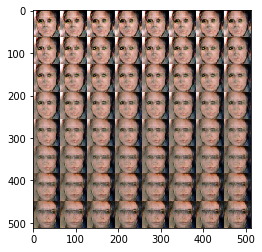

In [89]:
batch_z = np.zeros([BATCH_SIZE,Z_DIM]).astype(np.float32)
z1 = np.random.uniform(-1,1,Z_DIM)
z2 = np.random.uniform(-1,1,Z_DIM)
for i in range(BATCH_SIZE):
    alpha = i/63.0
    batch_z[i,...] = alpha*z1 + (1-alpha)*z2
    load_dir = 'checkpoint'
with tf.Session() as sess:
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    print(samples.shape)
img = merge(inverse_transform(samples), [MERGE_X, BATCH_SIZE//MERGE_X])
print(img.shape)
plt.imshow((255*img).astype(np.uint8))
plt.show()

# Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

Reading checkpoints...


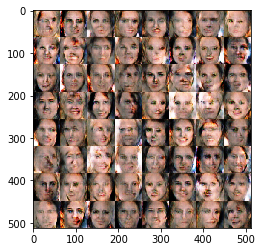

In [79]:
batch_z2 = np.zeros([BATCH_SIZE,Z_DIM]).astype(np.float32)
load_dir = 'checkpoint'
for i in range(BATCH_SIZE):
    batch_z2[i,...] = np.random.uniform(-1,1,Z_DIM)
with tf.Session() as sess:
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
    samples2 = sess.run(G, feed_dict={z: batch_z2, is_training: False} )
    
img2 = merge(inverse_transform(samples2), [8, BATCH_SIZE//8])
plt.imshow((255*img2).astype(np.uint8))

In [84]:
smiling_indices = [0,9,25,31,36]
non_smiling_indices = [1,2,16,48,49]
smile_vectors = np.zeros([5,Z_DIM]).astype(np.float32)
nonsmile_vectors = np.zeros([5,Z_DIM]).astype(np.float32)
for i in range(5):
    smile_vectors[i,...] = batch_z2[smiling_indices[i],...]
    nonsmile_vectors[i,...] = batch_z2[non_smiling_indices[i],...]
mean_smile = np.mean(smile_vectors,axis=0)
mean_non_smile = np.mean(nonsmile_vectors,axis=0)
smile_vector = mean_smile - mean_non_smile

Reading checkpoints...


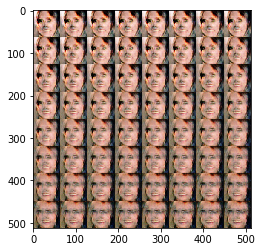

In [90]:
batch_smile = np.zeros([BATCH_SIZE,Z_DIM]).astype(np.float32)
for i in range(BATCH_SIZE):
    batch_smile[i,...] = batch_z[i,...] + smile_vector
with tf.Session() as sess:
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
    samples_smile = sess.run(G, feed_dict={z: batch_smile, is_training: False} )
img_smile = merge(inverse_transform(samples_smile), [MERGE_X, BATCH_SIZE//MERGE_X])
plt.imshow((255*img_smile).astype(np.uint8))

If faces looks really cool, add bonus 1 point to your score.